In [345]:
# import libraries
import warnings
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

warnings.filterwarnings('ignore')
%matplotlib inline

# for extraction of latitude & longitude
from geopy.geocoders import Nominatim 

### Let's have a look at our data.

In [346]:
data_file_req = 'data_req.csv'
data_file_with_lat_long = 'data-lat-long.csv' # Start from Check point 1
data_file_processed = 'data-lat-long-req.csv'
df = pd.read_csv(data_file_req, index_col=0)
df = df[[x for x in df.columns if 'Job_senior_' not in x]]
df.head(3) # company name

,search_term,job_url,job_title,job_categories,job_location,job_employment_type,job_seniority,job_last_posted_date,job_expiry_date,job_description,job_company_name,job_company_info,job_requirement,min_salary,max_salary
0,data scientist,/job/data-scientist-singapore-power-5731c18be1...,Data Scientist,Information Technology,"SP GROUP BUILDING, 2 KALLANG SECTOR 349277",Full Time,Professional,Posted 28 Jan 2019,Closing on 27 Feb 2019,Why Work for Us We Power the Nation. Make the...,SINGAPORE POWER LIMITED,SINGAPORE POWER LIMITED\r\nA leading energy ut...,What You'll Need We are looking for Passion an...,4000.0,8000.000000
1,data scientist,/job/senior-data-scientist-singapore-power-b8f...,Senior Data Scientist,Information Technology,"SP GROUP BUILDING, 2 KALLANG SECTOR 349277",Full Time,Middle Management,Posted 28 Jan 2019,Closing on 27 Feb 2019,Why Work for Us We Power the Nation. Make the...,SINGAPORE POWER LIMITED,SINGAPORE POWER LIMITED\r\nA leading energy ut...,What You'll Need We are looking for Passion an...,8000.0,14000.000000
2,data scientist,/job/data-scientist-spotify-singapore-1801998a...,Data Scientist,Others,"MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...",Permanent,Executive,Posted 28 Jan 2019,Closing on 27 Feb 2019,We seek an outstanding Data Scientist to join ...,SPOTIFY SINGAPORE PTE. LTD.,"At Spotify, we’re passionate about providing t...",Who you are Degree in Computer Science/Engine...,7500.0,9166.666667


### EDA  

In [3]:
df.shape # there are 2100 job postings & 15 features.

(2100, 15)

In [4]:
len(df.job_url.unique()) 
# there are 2057 unique jobs postings. 
# given that a company can be looking for one single person to do a data analysis + data scientist job, 
# duplicated postings among different search terms are possible. 

2057

In [5]:
df.isnull().sum().sort_values(ascending=False).head(14)/len(df) 
# determines whether we need to remove / impute null values before fitting into models.

job_location            0.275238
job_company_info        0.140000
max_salary              0.128571
min_salary              0.128571
job_requirement         0.061429
job_seniority           0.046190
job_company_name        0.037619
job_description         0.037619
job_expiry_date         0.037619
job_last_posted_date    0.037619
job_employment_type     0.037619
job_categories          0.037619
job_title               0.037619
job_url                 0.000000
dtype: float64

In [6]:
for column_name in df.columns:
    df = df[~df[column_name].isnull()]
    
df.shape # since the min requirement is 1000 job postings, we still hit the criteria. 

(1345, 15)

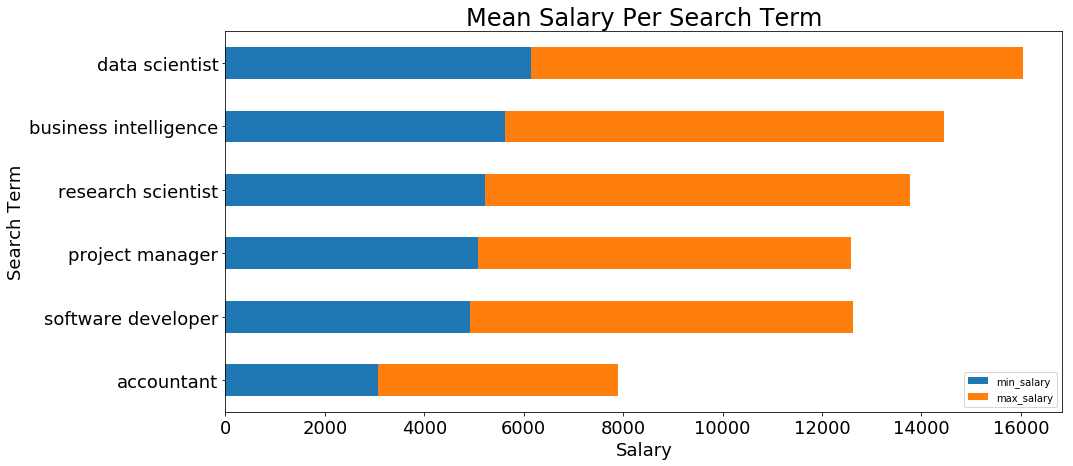

In [7]:
g = df.groupby(by='search_term').mean()[['min_salary', 'max_salary']].sort_values(by='min_salary').plot(kind='barh', stacked=True, figsize=(15,7), fontsize=18)
g.set_title('Mean Salary Per Search Term', fontsize=24)
g.set_xlabel('Salary', fontsize=18)
g.set_ylabel('Search Term', fontsize=18);

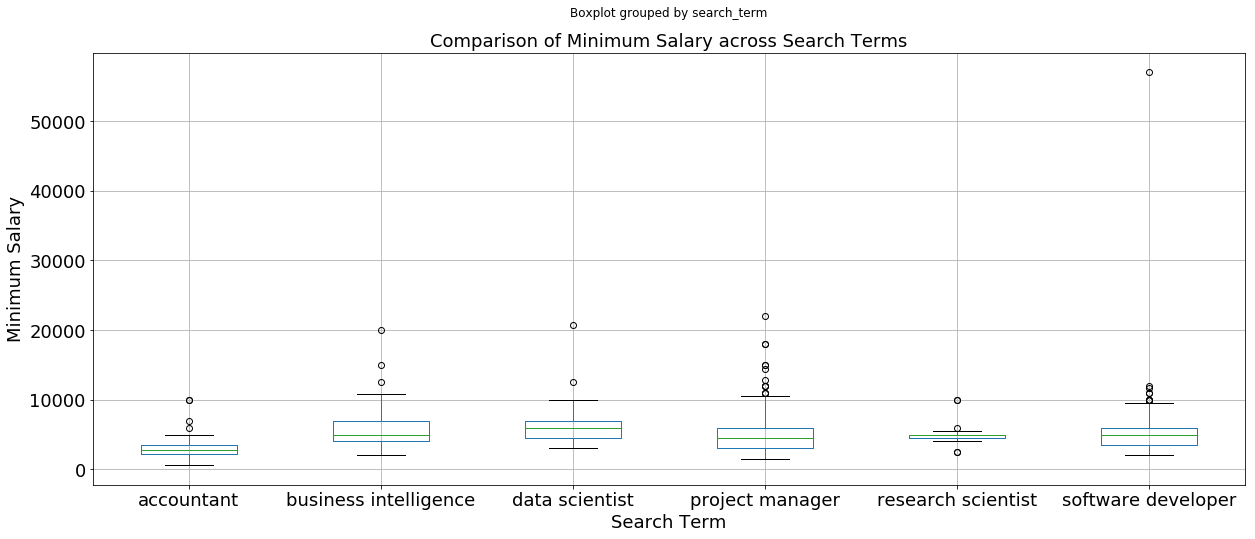

In [8]:
# as normally when applicants enter a new job, we get the "minimum salary". Let's look closer on this.
g = df[['search_term', 'min_salary']].boxplot(by='search_term', figsize=(20,8), fontsize=18)
g.set_title('Comparison of Minimum Salary across Search Terms', fontsize=18)
g.set_ylabel('Minimum Salary', fontsize=18)
g.set_xlabel('Search Term', fontsize=18);

In [9]:
# let's observe the outlier.
df[df.min_salary>50000]

,search_term,job_url,job_title,job_categories,job_location,job_employment_type,job_seniority,job_last_posted_date,job_expiry_date,job_description,job_company_name,job_company_info,job_requirement,min_salary,max_salary
916,software developer,/job/new-grad-senior-software-engineer-visa-wo...,"New Grad, Senior Software Engineer (Master's D...",Information Technology,71 ROBINSON ROAD 068895,Full Time,Fresh/entry level,Posted 04 Jan 2019,Closing on 03 Feb 2019,"Common Purpose, Uncommon Opportunity. Everyone...",VISA WORLDWIDE PTE. LIMITED,\r\n\tVISA WORLDWIDE PTE. LIMITED\r\n,"So what are we looking for in a New Grad, Soft...",57000.0,80000.0


### Surprisingly, it wasn't an error caused by the webscraping process. Below is the actual webpage.

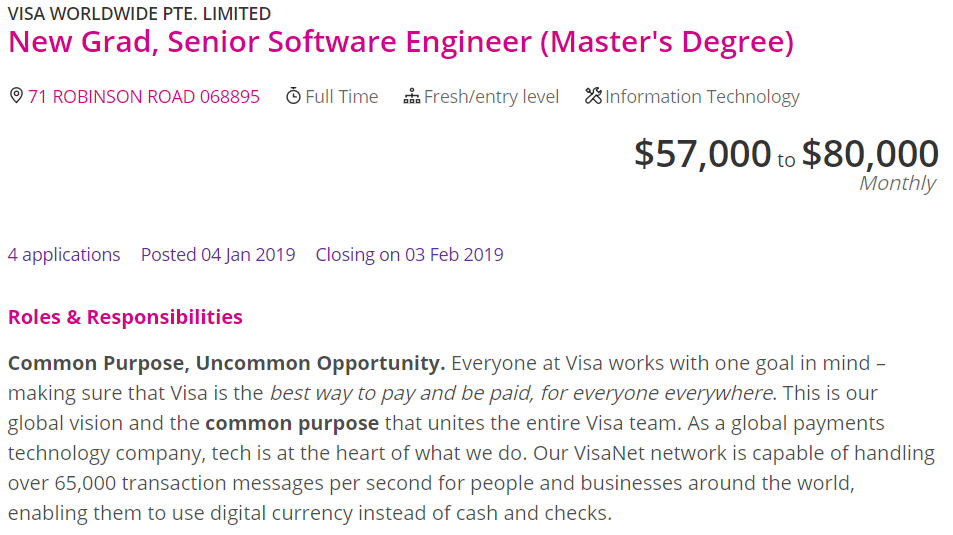

In [10]:
# However, it is highly likely for a monthly salary of >50k per month.
# Let's remove this outlier.

df = df[df.min_salary<50000]
df.shape

(1344, 15)

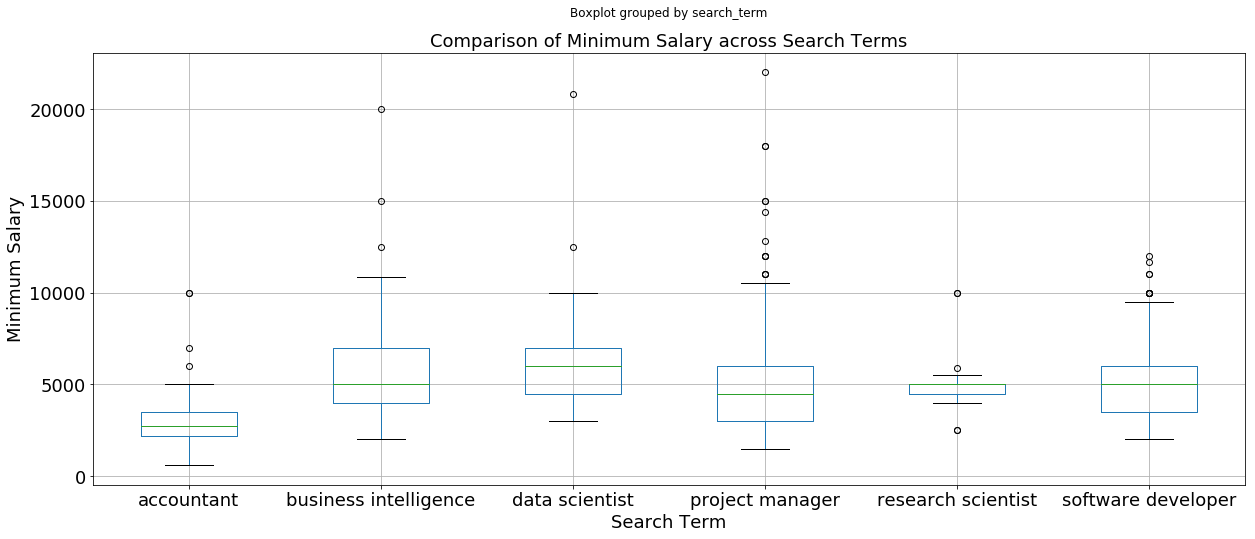

In [11]:
# let's plot the same boxplot, but this time without the outlier.
g = df[['search_term', 'min_salary']].boxplot(by='search_term', figsize=(20,8), fontsize=18)
g.set_title('Comparison of Minimum Salary across Search Terms', fontsize=18)
g.set_ylabel('Minimum Salary', fontsize=18)
g.set_xlabel('Search Term', fontsize=18);

#### From the box plot above, we observe that jobs with highest median salaries are data scientist, business intelligence and software developer.

In [12]:
# Feature Engineering - 
# Get number of days from time posted to time expiry (to determine "urgency")

df_clean = df.copy(deep=True)

def extract_date(x, text):
    try:
        return datetime.strptime(x.split(text)[1].strip(), '%d %b %Y')
    except:
        return np.NaN

def count_days(x):
    try:
        return int(str(x.job_expiry_date_new-x.job_last_posted_date_new).split('days')[0])
    except:
        return np.NaN

df_clean['job_last_posted_date_new'] = df_clean.job_last_posted_date.map(lambda x:extract_date(x,'Posted'))
df_clean['job_expiry_date_new'] = df_clean.job_expiry_date.map(lambda x:extract_date(x,'Closing on'))

df_clean['count_days_urgency'] = df_clean[['job_last_posted_date_new','job_expiry_date_new']].apply(count_days, axis=1)
df_clean[['job_last_posted_date','job_expiry_date', 'job_last_posted_date_new','job_expiry_date_new', 'count_days_urgency']].head()

,job_last_posted_date,job_expiry_date,job_last_posted_date_new,job_expiry_date_new,count_days_urgency
0,Posted 28 Jan 2019,Closing on 27 Feb 2019,2019-01-28,2019-02-27,30
1,Posted 28 Jan 2019,Closing on 27 Feb 2019,2019-01-28,2019-02-27,30
2,Posted 28 Jan 2019,Closing on 27 Feb 2019,2019-01-28,2019-02-27,30
3,Posted 28 Jan 2019,Closing on 27 Feb 2019,2019-01-28,2019-02-27,30
4,Posted 28 Jan 2019,Closing on 27 Feb 2019,2019-01-28,2019-02-27,30


In [13]:
# Feature Engineering - Dummy variables for search_term
df_clean = pd.concat([df_clean, pd.get_dummies(df_clean.search_term, prefix='job_searchterm')], axis=1)
df_clean[['search_term'] + [x for x in df_clean.columns if 'job_searchterm' in x]].head()

,search_term,job_searchterm_accountant,job_searchterm_business intelligence,job_searchterm_data scientist,job_searchterm_project manager,job_searchterm_research scientist,job_searchterm_software developer
0,data scientist,0,0,1,0,0,0
1,data scientist,0,0,1,0,0,0
2,data scientist,0,0,1,0,0,0
3,data scientist,0,0,1,0,0,0
4,data scientist,0,0,1,0,0,0


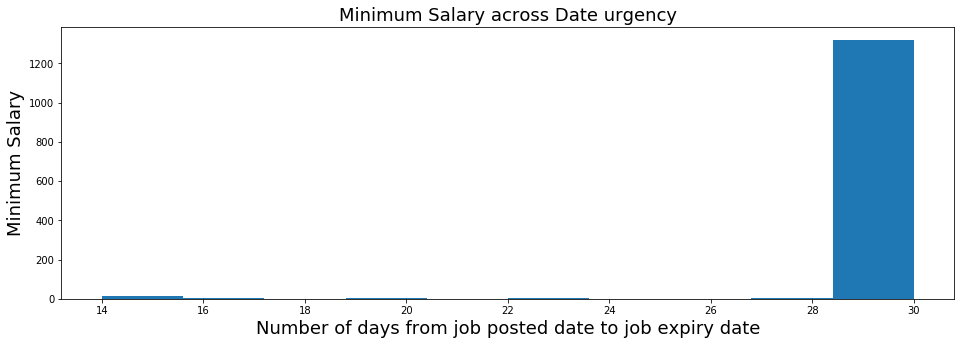

In [14]:
# Feature Engineering - Does Urgency affect Min Salary? 

g = df_clean['count_days_urgency'].plot(kind='hist', figsize=(16,5))
g.set_title('Minimum Salary across Date urgency', fontsize=18)
g.set_ylabel('Minimum Salary', fontsize=18)
g.set_xlabel('Number of days from job posted date to job expiry date', fontsize=18);

### We won't be able to determine if date urgency affect min salary as most job postings expire in 30 days. 

In [15]:
# Feature Engineering - get multi-class label for job_employment_type

def multiclass_label(data, column_name):
    # get unique labels 
    temp = [x.split(',') for x in data[column_name].unique()]
    labels = []
    for position in temp:
        labels.extend(position)
    unique_labels = list(set([x.strip().lower() for x in labels]))
    print(unique_labels)

    for label in unique_labels:
        data[column_name+'_'+label] = data[column_name].map(lambda x:1 if label in x.lower() else 0)
    return data

df_clean = multiclass_label(df_clean, 'job_employment_type')
df_clean[['job_employment_type'] + [x for x in df_clean.columns if 'Job_ET_' in x]].head() # sanity check.

['contract', 'freelance', 'part time', 'full time', 'temporary', 'flexi work', 'internship', 'permanent']


,job_employment_type
0,Full Time
1,Full Time
2,Permanent
3,Full Time
4,Full Time


In [16]:
# Feature Engineering - get multi-class label for job_categpry
    
df_clean = multiclass_label(df_clean, 'job_categories')
df_clean[['job_categories'] + ['job_categories_information technology'] + [x for x in df_clean.columns if 'job_categories_' in x]].head() # sanity check.

['engineering', 'general work', 'human resources', 'customer service', 'others', 'banking and finance', 'building and construction', 'security and investigation', 'purchasing / merchandising', 'sales / retail', 'advertising / media', 'manufacturing', 'repair and maintenance', 'design', 'consulting', 'travel / tourism', 'hospitality', 'logistics / supply chain', 'insurance', 'general management', 'events / promotions', 'real estate / property management', 'legal', 'environment / health', 'information technology', 'accounting / auditing / taxation', 'medical / therapy services', 'risk management', 'telecommunications', 'sciences / laboratory / r&d', 'healthcare / pharmaceutical', 'professional services', 'entertainment', 'admin / secretarial', 'marketing / public relations', 'architecture / interior design']


,job_categories,job_categories_information technology,job_categories_engineering,job_categories_general work,job_categories_human resources,job_categories_customer service,job_categories_others,job_categories_banking and finance,job_categories_building and construction,job_categories_security and investigation,...,job_categories_medical / therapy services,job_categories_risk management,job_categories_telecommunications,job_categories_sciences / laboratory / r&d,job_categories_healthcare / pharmaceutical,job_categories_professional services,job_categories_entertainment,job_categories_admin / secretarial,job_categories_marketing / public relations,job_categories_architecture / interior design
0,Information Technology,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Information Technology,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Others,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Information Technology,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Banking and Finance,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Feature Engineering - get multi-class label for job_seniority

# # get unique job_seniority 
temp = [x.lower().split(',') for x in df_clean.job_seniority.unique()]
seniority = []
for x in temp:
    seniority.extend(x)
unique_seniority = list(set([x.strip() for x in seniority]))
print(unique_seniority)

# output: 
# ['fresh/entry level', 'middle management', 'junior executive','senior management', 
#  'manager', 'senior executive', 'executive', 'non-executive', 'professional']

# seniority
junior = ['fresh/entry level','junior executive']
senior = ['senior management', 'senior executive']
# others = 'non-executive', 'professional', 'manager',middle management, 'executive',

# management or executive or not 
management = ['senior management', 'manager', 'middle management']
executive = ['junior executive' ,'executive', 'senior executive']
# others = 'fresh/entry level', 'non-executive', 'professional', 

tmp = {
    'junior': junior,
    'senior': senior,
    'management': management,
    'executive': executive,
}
for position in tmp.items():
    df_clean['Job_seniority_'+position[0]] = df_clean.job_seniority.map(lambda x:1 if x.lower() in position[1] else 0)
    
df_clean[['job_seniority'] + [x for x in df_clean.columns if 'Job_seniority_' in x]].head() # sanity check.

['senior management', 'non-executive', 'middle management', 'executive', 'manager', 'fresh/entry level', 'senior executive', 'professional', 'junior executive']


,job_seniority,Job_seniority_junior,Job_seniority_senior,Job_seniority_management,Job_seniority_executive
0,Professional,0,0,0,0
1,Middle Management,0,0,1,0
2,Executive,0,0,0,1
3,Senior Executive,0,1,0,1
4,Professional,0,0,0,0


In [21]:
# feature engineering - Latitude & Longitude
def get_lat_long(location):
    if ',' in str(location):
        location = location.split(',')[1]
    try:
        geolocator = Nominatim(user_agent='GA Project 4')
        location_p = geolocator.geocode(location)
        print(location)
        print((location_p.latitude, location_p.longitude))
        return location_p.latitude, location_p.longitude
    except:
        return None, None

lat_long = df_clean.job_location.map(get_lat_long)
df_clean['Latitude'] = pd.DataFrame(lat_long).apply(lambda x: x[0][0], axis=1)
df_clean['Longitude'] = pd.DataFrame(lat_long).apply(lambda x: x[0][1], axis=1)
df_clean.to_csv('data-lat-long-req.csv') # as this process takes a long time, we save it to data-lat-long.csv

 2 KALLANG SECTOR 349277
(1.3238948, 103.8738535)
 2 KALLANG SECTOR 349277
(1.3238948, 103.8738535)
 8 MARINA BOULEVARD 018981
(1.2801372, 103.8543912)
 30 CECIL STREET 049712
(1.2828426, 103.849928486267)
 10 MARINA BOULEVARD 018983
(1.27958235, 103.8538296)
 8 MARINA BOULEVARD 018981
(1.2801372, 103.8543912)
 111 SOMERSET ROAD 238164
16 TAMPINES INDUSTRIAL CRESCENT 528604
(1.3752303, 103.9290238)
1 DEPOT CLOSE 109841
(51.6165745, 7.3231724)
 10 ANSON ROAD 079903
(1.275755, 103.845899858558)
 10 ANSON ROAD 079903
(1.275755, 103.845899858558)
 10 ANSON ROAD 079903
(1.275755, 103.845899858558)
 60 MACPHERSON ROAD 348615
(1.3275858, 103.870629818407)
 8 TEMASEK BOULEVARD 038988
(1.29522995, 103.859599091005)
 3 FUSIONOPOLIS WAY 138633
(1.2985319, 103.7883403)
 61 UBI ROAD 1 408727
(1.332271, 103.8901303)
 31 EXETER ROAD 239732
(1.2989247, 103.838148823508)
 3 FUSIONOPOLIS WAY 138633
(1.2985319, 103.7883403)
 50 NANYANG AVENUE 639798
(1.34646005, 103.682847710825)
79 AYER RAJAH CRESCENT 1

1003 BUKIT MERAH CENTRAL 159836
(1.2836198, 103.8147522)
 391A ORCHARD ROAD 238873
 391A ORCHARD ROAD 238873
 50 RAFFLES PLACE 048623
(1.2847201, 103.8520602)
 10 ANSON ROAD 079903
(1.275755, 103.845899858558)
 8 MARINA VIEW 018960
(1.2787583, 103.8508921)
21 LOWER KENT RIDGE ROAD 119077
(1.2936791, 103.784942)
 7500A BEACH ROAD 199591
(1.2994476, 103.8600946)
 6 TEMASEK BOULEVARD 038986
(1.29463, 103.859773649048)
 3A INTERNATIONAL BUSINESS PARK 609935
 3A INTERNATIONAL BUSINESS PARK 609935
15 CHANGI BUSINESS PARK CENTRAL 1 486057
(1.3372323, 103.964049293735)
 51 CHANGI BUSINESS PARK CENTRAL 2 486066
(1.33471, 103.96517)
 8 BURN ROAD 369977
(53.5916687, -0.6861458)
 1 COLEMAN STREET 179803
(1.2913726, 103.8510777)
 1 WALLICH STREET 078881
(1.2770467, 103.845472626367)
 3A INTERNATIONAL BUSINESS PARK 609935
 50 RAFFLES PLACE 048623
(1.2847201, 103.8520602)
6 BATTERY ROAD 049909
(1.28551495, 103.851838596266)
6 BATTERY ROAD 049909
(1.28551495, 103.851838596266)
 36 CHANGI SOUTH STREET 

 18 CROSS STREET 048423
(1.2834925, 103.8465903)
 10 UBI CRESCENT 408564
(1.3258012, 103.8950548)
 80 BENDEMEER ROAD 339949
(1.3172732, 103.8632794)
 80 BENDEMEER ROAD 339949
(1.3172732, 103.8632794)
 60 PAYA LEBAR ROAD 409051
(1.319072, 103.892618)
 160 ROBINSON ROAD 068914
 1 WALLICH STREET 078881
(1.2770467, 103.845472626367)
 4 SHENTON WAY 068807
(1.2788363, 103.849551574312)
 8 MARINA VIEW 018960
(1.2787583, 103.8508921)
 8 MARINA VIEW 018960
(1.2787583, 103.8508921)
 1 WALLICH STREET 078881
(1.2770467, 103.845472626367)
2 GUL AVENUE 629649
(1.3148053, 103.6680971)
 61 SCIENCE PARK ROAD 117525
 3 SHENTON WAY 068805
(1.2785707, 103.850092671947)
 5 TEMASEK BOULEVARD 038985
(1.29452575, 103.857972206178)
 5 TEMASEK BOULEVARD 038985
(1.29452575, 103.857972206178)
1003 BUKIT MERAH CENTRAL 159836
(1.2836198, 103.8147522)
1003 BUKIT MERAH CENTRAL 159836
(1.2836198, 103.8147522)
 1 PEMIMPIN DRIVE 576151
(1.3523593, 103.8429071)
 1 PEMIMPIN DRIVE 576151
(1.3523593, 103.8429071)
 111 NORTH

 3 SHENTON WAY 068805
(1.2785707, 103.850092671947)
 5 TEMASEK BOULEVARD 038985
(1.29452575, 103.857972206178)
 12 AYER RAJAH CRESCENT 139941
(1.2981687, 103.7880469)
 3 FUSIONOPOLIS WAY 138633
(1.2985319, 103.7883403)
 2 WOODLANDS SECTOR 1 738068
(1.4531758, 103.8057102)
 3 SHENTON WAY 068805
(1.2785707, 103.850092671947)
 3 SHENTON WAY 068805
(1.2785707, 103.850092671947)
 2 VENTURE DRIVE 608526
(1.3302455, 103.7437857)
 5 LITTLE ROAD 536983
(1.3385137, 103.886205)
39 JOO KOON CIRCLE 629105
 140 PAYA LEBAR ROAD 409015
(1.3273401, 103.890882496758)
 81 UBI AVENUE 4 408830
(1.3333929, 103.8916342)
 3 SHENTON WAY 068805
(1.2785707, 103.850092671947)
 8 MARINA VIEW 018960
(1.2787583, 103.8508921)
 12 AYER RAJAH CRESCENT 139941
(1.2981687, 103.7880469)
 3 FUSIONOPOLIS WAY 138633
(1.2985319, 103.7883403)
 51 UBI AVENUE 1 408933
 5 LITTLE ROAD 536983
(1.3385137, 103.886205)
 18 SIN MING LANE 573960
(1.3574088, 103.8337839)
 3 FUSIONOPOLIS WAY 138633
(1.2985319, 103.7883403)
 3 SHENTON WAY 0

21 LOWER KENT RIDGE ROAD 119077
(1.2936791, 103.784942)
 16 COLLYER QUAY 049318
(1.2842079, 103.852661)
 28 GENTING LANE 349585
(1.3282359, 103.873150811872)
 16 RAFFLES QUAY 048581
(1.2813384, 103.85091665)
 1 COLEMAN STREET 179803
(1.2913726, 103.8510777)
21 LOWER KENT RIDGE ROAD 119077
(1.2936791, 103.784942)
 101A UPPER CROSS STREET 058358
 1 COLEMAN STREET 179803
(1.2913726, 103.8510777)
 1 MAGAZINE ROAD 059567
(26.3178133, 89.4501075)
395A CHANGI ROAD 419843
 750 CHAI CHEE ROAD 469000
(1.3238125, 103.9221574)
 1 COLEMAN STREET 179803
(1.2913726, 103.8510777)
 9 TEMASEK BOULEVARD 038989
(1.29564995, 103.859006308713)
 8 MARINA VIEW 018960
(1.2787583, 103.8508921)
4 CHIN BEE DRIVE 619855
(1.3364304, 103.7152056)
 1 MAGAZINE ROAD 059567
(26.3178133, 89.4501075)
 10 SHENTON WAY 079117
(1.27469415, 103.846677185533)
23 ROCHESTER PARK 139234
(1.3048896, 103.7882154)
 8 CHANGI NORTH STREET 1 498829
(1.3509112, 103.9686822)
 8 MARINA VIEW 018960
(1.2787583, 103.8508921)
 5 TEMASEK BOULEV

 205 BALESTIER ROAD 329682
 1 CHANGI BUSINESS PARK CRESCENT 486025
(1.3348602, 103.9677812)
 1 SCOTTS ROAD 228208
(1.3059181, 103.8320152)
 300 BEACH ROAD 199555
(1.30102205, 103.862492961574)
 1 CHANGI BUSINESS PARK CRESCENT 486025
(1.3348602, 103.9677812)
 1 CHANGI BUSINESS PARK CRESCENT 486025
(1.3348602, 103.9677812)
 81 UBI AVENUE 4 408830
(1.3333929, 103.8916342)
 160 ROBINSON ROAD 068914
36 KIAN TECK ROAD 628781
 111 NORTH BRIDGE ROAD 179098
(1.292054, 103.850739)
 1 SUNVIEW ROAD 627615
(1.3169992, 103.6981433)
 7 BENOI CRESCENT 629971
(1.3200209, 103.6927313)
 1 WALLICH STREET 078881
(1.2770467, 103.845472626367)
 67 UBI AVENUE 1 408942
(1.3242909, 103.892384747159)
 1 COLEMAN STREET 179803
(1.2913726, 103.8510777)
 1 RAFFLES PLACE 048616
(1.2847415, 103.8510968)
 2 AYER RAJAH CRESCENT 139935
(1.2981687, 103.7880469)
 38 JALAN PEMIMPIN 577178
 8 WILKIE ROAD 228095
(1.303284, 103.8471418)
 14 ROBINSON ROAD 048545
(1.2821538, 103.850783)
 138 MARKET STREET 048946
(48.2149406, -69

1 RAFFLES QUAY 048583
(1.2800515, 103.8506446)
 6001 BEACH ROAD 199589
 3 LITTLE ROAD 536982
(31.93132815, 35.176209245736)
33 KAKI BUKIT ROAD 6 415808
 3 LITTLE ROAD 536982
(31.93132815, 35.176209245736)
 77 ROBINSON ROAD 068896
(1.2781063, 103.8485244)
 138 MARKET STREET 048946
(48.2149406, -69.6786336)
 12 MARINA BOULEVARD 018982
(26.0894327, -80.1656957)
 3 SHENTON WAY 068805
(1.2785707, 103.850092671947)
 135 MIDDLE ROAD 188975
(1.2994412, 103.8526381)
 1 WALLICH STREET 078881
(1.2770467, 103.845472626367)
1 PANDAN CRESCENT 128461
(1.3015885, 103.761484153451)
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 315 OUTRAM ROAD 169074
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 4 SU

 87 MARINE PARADE CENTRAL 440087
10 JALAN SAMULUN 629124
(1.3042662, 103.6971055)
 50 RAFFLES PLACE 048623
(1.2847201, 103.8520602)
 23A SERANGOON NORTH AVENUE 5 554369
211 WOODLANDS AVENUE 9 738960
59 GUL ROAD 629354
8 LORONG BAKAR BATU 348743
(1.3277909, 103.8725761)
13A PANDAN CRESCENT 128478
 1 NORTH BRIDGE ROAD 179094
(1.2899732, 103.849250553277)
 11 LAGUNA GOLF GREEN 488047
(1.3213074, 103.964121832514)
 20 ANSON ROAD 079912
(1.27526635, 103.845641980126)
 8 SHENTON WAY 068811
(1.27571645, 103.847277659665)
 1 COMMONWEALTH LANE 149544
(1.3047676, 103.7962879)
 10 UBI CRESCENT 408564
(1.3258012, 103.8950548)
 1 MARINA BOULEVARD 018989
(1.2822549, 103.852696683845)
 5001 BEACH ROAD 199588
(1.3028424, 103.8653096)
33 KAKI BUKIT ROAD 6 415808
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 4 SUNGEI KADUT STREET 2 729226
(1.4145413, 103.7495436)
 26 PIONEER CRES

### Check point 1 

In [352]:
# Run this only if loading data_file_processed
# df_clean = pd.read_csv(data_file_processed, index_col=0)

In [353]:
df_clean = df_clean[~df_clean.Latitude.isnull()]

In [354]:
df_clean.job_requirement.head() # it is not clean.

0    What You'll Need We are looking for Passion an...
1    What You'll Need We are looking for Passion an...
2    Who you are  Degree in Computer Science/Engine...
3    Requirements    ● Industry experience in data ...
4    Key Experience & Skills   Strong academic back...
Name: job_requirement, dtype: object

In [355]:
def clean_text(text):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    stop_words = stopwords.words('english')
    tokens = word_tokenize(text)
    words = [word.lower() for word in tokens if word.isalpha()]
    words_clean = [x for x in words if x not in stop_words]
    stemmed = [porter.stem(word) for word in words_clean]
    return str(' '.join(stemmed))
    
df_clean['job_requirement_clean'] = df_clean.job_requirement.map(clean_text)
df_clean[['job_requirement', 'job_requirement_clean']].head()

,job_requirement,job_requirement_clean
0,What You'll Need We are looking for Passion an...,need look passion profici person softwar engin...
1,What You'll Need We are looking for Passion an...,need look passion profici person softwar engin...
2,Who you are Degree in Computer Science/Engine...,degre comput mathemat statist econom anoth qua...
3,Requirements ● Industry experience in data ...,requir industri experi data mine data scienc u...
4,Key Experience & Skills Strong academic back...,key experi skill strong academ background mast...


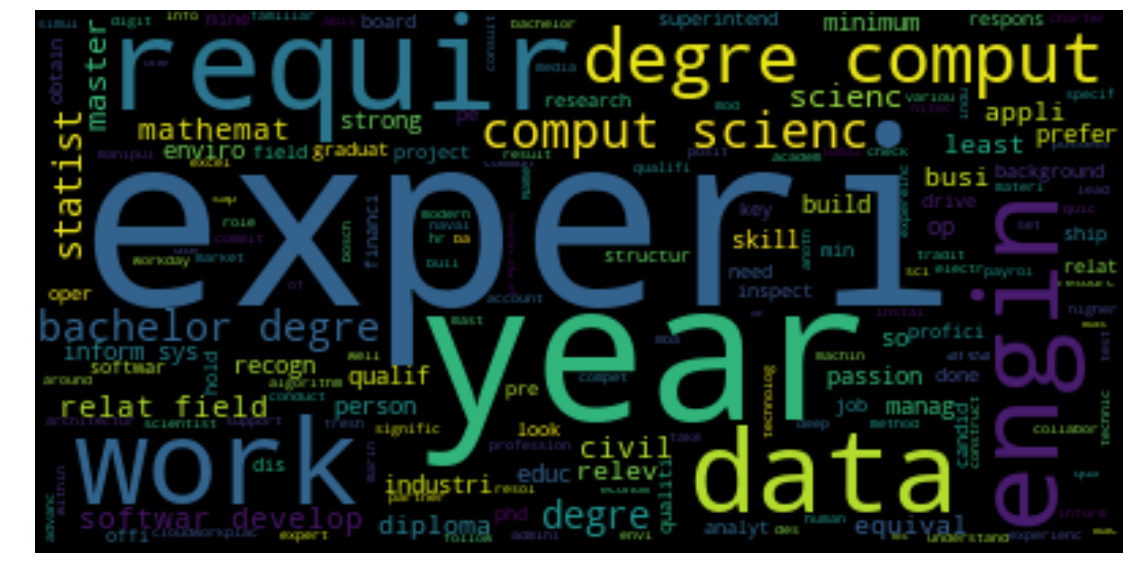

In [356]:
# visualise words used in job_requirements
from wordcloud import WordCloud
stopwords= []
wc = WordCloud(stopwords=stopwords)
wc.generate_from_text(str(df_clean[df_clean['search_term'] != 'accountant'].job_requirement_clean.map(lambda x:x.lower())))
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [357]:
# extract dummy variables for important words (e.g. certain skills) found in job_requirement
skills = [
    'experi', 'year', 'experi', 'data', 'work', 'bachelor degre', 'engin', 'statist', 'passion', 'civil',
    'degre', 'inform sys', 'bachelor', 'master', 'mathemat', 'diploma', 'research', 'comput', 'candid', ' scienc'
 ]
for skill in skills:
    df_clean['skill_in_'+skill] = df_clean.job_requirement_clean.map(lambda x:1 if skill in x else 0)
    
df_clean[['job_requirement_clean', 'skill_in_research']].head()

,job_requirement_clean,skill_in_research
0,need look passion profici person softwar engin...,0
1,need look passion profici person softwar engin...,0
2,degre comput mathemat statist econom anoth qua...,0
3,requir industri experi data mine data scienc u...,0
4,key experi skill strong academ background mast...,1


In [358]:
df_clean = pd.concat([df_clean, pd.get_dummies(df_clean.job_company_name, prefix='company_name')], axis=1)

In [359]:
# extract numerical columns for modeling
numerical_columns = []
for column_name in df_clean.columns:
    if df_clean[column_name].dtypes != object and df_clean[column_name].dtypes != 'datetime64[ns]':
        numerical_columns.append(column_name)

df_numerical = df_clean[numerical_columns]
df_numerical.head()

,min_salary,max_salary,count_days_urgency,job_searchterm_accountant,job_searchterm_business intelligence,job_searchterm_data scientist,job_searchterm_project manager,job_searchterm_research scientist,job_searchterm_software developer,job_employment_type_contract,...,company_name_WORKS APPLICATIONS SINGAPORE PTE. LTD.,company_name_WSP CONSULTANCY PTE. LTD.,company_name_XPLORE INFOCOMZ SOLUTION (PTE. LTD.),company_name_ZAGRO SINGAPORE PTE LTD,company_name_ZALORA SOUTH EAST ASIA PTE. LTD.,company_name_ZARA @ ISOTEAM PTE. LTD.,company_name_ZENDESK SINGAPORE PTE. LTD.,company_name_ZHENGDA CORPORATION PTE. LTD.,company_name_ZOOLOO INFORMATION SYSTEMS PTE. LTD.,company_name_ZUHLKE ENGINEERING PTE. LTD.
0,4000.0,8000.000000,30,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8000.0,14000.000000,30,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7500.0,9166.666667,30,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7000.0,9500.000000,30,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20800.0,33000.000000,30,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [360]:
# Set Predictor & Target variables - Predict whether min_salary is above median salary 
X = df_numerical[[x for x in df_numerical.columns if x not in ['min_salary', 'max_salary']]]
y = df_numerical['min_salary']

y_median = y.median()
print('median min_salary is $', y_median, '\n') 
y_above_median = y.map(lambda x: 1 if x>=y_median else 0)

print(y_above_median.value_counts()/len(y_above_median)) 

median min_salary is $ 5000.0 

1    0.515996
0    0.484004
Name: min_salary, dtype: float64


#### Do a simple model

In [361]:
def pipeline_qf(X, y):
    data_scores = []
    sampling_methods = [
        SMOTE(random_state=42), 
        RandomOverSampler(random_state=42), 
        RandomUnderSampler(random_state=42)
    ]

    for sampling_method in sampling_methods:
        X_res, y_res = sampling_method.fit_resample(X, y)

        model = RandomForestClassifier()
        score = round(np.mean(cross_val_score(model, X_res, y_res, cv=10, scoring='roc_auc')), 3)
        data_scores.append([sampling_method, model, score])

        model = SVC()
        score = round(np.mean(cross_val_score(model, X_res, y_res, cv=10, scoring='roc_auc')), 3)
        data_scores.append([sampling_method, model, score])

    return pd.DataFrame(data_scores, columns=['sampler_method', 'model', 'roc_auc']).sort_values(by='roc_auc', ascending=False).head()
    
pipeline_qf(X, y_above_median) # these are the top 5 models.

,sampler_method,model,roc_auc
2,"RandomOverSampler(random_state=42, ratio=None,...","RandomForestClassifier(bootstrap=True, class_w...",0.781
4,"RandomUnderSampler(random_state=42, ratio=None...","RandomForestClassifier(bootstrap=True, class_w...",0.760
0,"SMOTE(k_neighbors=5, kind='deprecated', m_neig...","RandomForestClassifier(bootstrap=True, class_w...",0.755
3,"RandomOverSampler(random_state=42, ratio=None,...","SVC(C=1.0, cache_size=200, class_weight=None, ...",0.741
1,"SMOTE(k_neighbors=5, kind='deprecated', m_neig...","SVC(C=1.0, cache_size=200, class_weight=None, ...",0.738


In [362]:
sampler = RandomOverSampler()
X_res, y_res =  sampler.fit_resample(X, y_above_median)
X_train, X_test, y_train, y_test_salary = train_test_split(X_res, y_res)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

In [363]:
y_pred_salary = [y for x,y in y_pred]
y_pred_salary[:10]

[0.3, 0.1, 0.8, 0.7, 0.2, 0.6, 0.4, 0.1, 0.0, 0.6]

In [364]:
pd.DataFrame(model.feature_importances_, index = X.columns, columns=['roc_auc']).sort_values(by='roc_auc', ascending=False).head()
# these are the strongest features that affect min_salary.

,roc_auc
Latitude,0.103979
Longitude,0.089230
skill_in_diploma,0.044426
Job_seniority_executive,0.027034
job_categories_accounting / auditing / taxation,0.024938


### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

In [365]:
# What components of a job posting distinguish data scientists from other data jobs?
df_subset_data = df_numerical[df_numerical.job_searchterm_accountant == 0] # remove accountant because it is not a "data job"
X = df_subset_data[[x for x in df_subset_data.columns if 'job_searchterm' not in x and 'skill_in_data scientist' not in x]]
y = df_subset_data['job_searchterm_data scientist']

In [366]:
pipeline_qf(X, y) # these are the top 5 models.

,sampler_method,model,roc_auc
2,"RandomOverSampler(random_state=42, ratio=None,...","RandomForestClassifier(bootstrap=True, class_w...",0.995
0,"SMOTE(k_neighbors=5, kind='deprecated', m_neig...","RandomForestClassifier(bootstrap=True, class_w...",0.991
3,"RandomOverSampler(random_state=42, ratio=None,...","SVC(C=1.0, cache_size=200, class_weight=None, ...",0.989
4,"RandomUnderSampler(random_state=42, ratio=None...","RandomForestClassifier(bootstrap=True, class_w...",0.926
1,"SMOTE(k_neighbors=5, kind='deprecated', m_neig...","SVC(C=1.0, cache_size=200, class_weight=None, ...",0.903


In [367]:
sampler = RandomOverSampler(random_state=42)
X_res, y_res = sampler.fit_resample(X, y)
model = RandomForestClassifier()
model.fit(X_res, y_res)
df_importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
df_importance.head(5) # these are the top factors in distinguishing data scientists from other data jobs. 

,importance
skill_in_statist,0.206223
skill_in_data,0.139875
skill_in_mathemat,0.055893
job_employment_type_contract,0.043054
max_salary,0.040291


In [373]:
# What features are important for distinguishing junior vs. senior positions?
df_numerical[[x for x in df_numerical.columns if 'Job_seniority' in x]].head()

,Job_seniority_junior,Job_seniority_senior,Job_seniority_management,Job_seniority_executive
0,0,0,0,0
1,0,0,1,0
2,0,0,0,1
3,0,1,0,1
4,0,0,0,0


In [374]:
# just get senior & junior jobs. some are in between (e.g. professional and cannot be determined.)
df_1 = df_numerical[df_numerical.Job_seniority_junior == 1]
df_2 = df_numerical[df_numerical.Job_seniority_senior == 1]
df_temp = pd.concat([df_1, df_2], axis=0)
X = df_temp[[x for x in df_temp.columns if x not in ['Job_seniority_junior', 'Job_seniority_senior']]]
y = df_temp['Job_seniority_junior']

pipeline_qf(X,y)

,sampler_method,model,roc_auc
2,"RandomOverSampler(random_state=42, ratio=None,...","RandomForestClassifier(bootstrap=True, class_w...",0.979
3,"RandomOverSampler(random_state=42, ratio=None,...","SVC(C=1.0, cache_size=200, class_weight=None, ...",0.947
0,"SMOTE(k_neighbors=5, kind='deprecated', m_neig...","RandomForestClassifier(bootstrap=True, class_w...",0.940
1,"SMOTE(k_neighbors=5, kind='deprecated', m_neig...","SVC(C=1.0, cache_size=200, class_weight=None, ...",0.902
4,"RandomUnderSampler(random_state=42, ratio=None...","RandomForestClassifier(bootstrap=True, class_w...",0.850


In [381]:
# use best results
sampling_method = RandomOverSampler()
X_res, y_res = sampling_method.fit_resample(X, y)

model = RandomForestClassifier()
model.fit(X,y)
pd.DataFrame(model.feature_importances_, index=X.columns, columns=['roc_auc']).sort_values(by='roc_auc', ascending=False).head(3)
# these are the top coefficients to predict seniority, which makes sense - senior staff often get higher pay than junior staff.

,roc_auc
max_salary,0.168319
min_salary,0.098829
Longitude,0.070653


In [371]:
# Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

In [372]:
df_clean.job_categories.value_counts().head(5) 

Information Technology              456
Engineering                         103
Accounting / Auditing / Taxation     74
Building and Construction            48
Banking and Finance                  38
Name: job_categories, dtype: int64

In [195]:
# Let's compare the top 2 industries
top_industries = list(df_clean.job_categories.value_counts().head(2).keys())
top_industries

['Information Technology', 'Engineering']

In [196]:
dfs = []
for industry in top_industries:
    dfs.append(df_clean[df_clean.job_categories == industry][['job_title', 'job_categories']])
    
df_merged = pd.concat(dfs, axis=0)
df_merged.job_categories = df_merged.job_categories.map(lambda x:1 if x==top_industries[0] else 0)
df_merged.head()

,job_title,job_categories
0,Data Scientist,1
1,Senior Data Scientist,1
3,Senior Data Scientist,1
10,Data Scientist,1
11,Data Scientist,1


In [197]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

X = df_merged.job_title
y = df_merged.job_categories

model = make_pipeline(
    CountVectorizer(lowercase=True, stop_words='english'), 
    RandomForestClassifier()
 )

round(np.mean(cross_val_score(model, X, y, cv = 10, scoring='roc_auc')),3)

0.825

In [198]:
model.fit(X,y)
df_coef = pd.DataFrame(
    model.named_steps['randomforestclassifier'].feature_importances_, 
    index=model.named_steps['countvectorizer'].get_feature_names(), 
    columns=['score']
).sort_values(by='score', ascending=False)

df_coef.head(8) 


,score
engineer,0.116718
project,0.073597
software,0.030896
senior,0.030609
site,0.023813
android,0.023603
developer,0.023298
manager,0.021450


> Title varies alot with industry (Information Technology vs. Engineering). 'engineer', 'project', 'developer' are the words that mattered the most.

## Summary
 In this project, we have predicted minimum salary with an AUC score of 0.78 with strong predictors being ‘Latitude, ‘Longitude’, ‘diploma in requirements’, and ‘seniority as executive’. It makes sense as companies with higher revenues (and thus higher salary) may be situated near the CBD, while having a diploma s
 hould also affect minimum salary. 
 
 In addition, we have also predicted components of a job posting that distinguishes data scientists from other jobs with an AUC score of 0.99. The high score in prediction was due to words such as “data”, statist”, “mathemat” appearing as part of job requirement in the job postings. This highlights the importance of math and statistics skills in order to be hired as a data scientist in the future. 
 
We also found out what are the important features in distinguishing junior vs. senior positions with an AUC score of 0.98. The strongest features are minimum salary, maximum salary, which makes sense as senior staff often receives higher salary than junior staff. 

 Finally, we find out if requirements for title vary significantly with different industries (Information Technology vs. Engineering) with an AUC of 0.83. Words like “engineer”, “project” are some of the words that appear very differently for job postings of the two industry. This would be useful for the website is predicting the job industry tags for their clients (the hiring companies).
 
Visualization plays a very important part of understanding the data. For example, when I was thinking of using “Date Posted” and “Date Expired On” to get a sense of how companies are urgent to get new employees affect salaries offered, I realised that most companies expires in 30 days, and the number of companies which does not has their job postings expire in 30 days are so little that it does not make sense to even use this as a predictor variable.
Apart from using multiple visualisation tools to better understand the scraped data, my approach to these problems was to extract meaningful numerical features from original predictor features (which only consisted of categorical features). Some of the features were also tricky to extract: such as multi-class categorical features. Some of the features were also subjective during extraction: for example, whether a professional is considered junior or senior staff. 

As the categorical classes were typically imbalanced from scraped data, I used imblearn’s RandonUnderSampling, RandomOverSampling, and SMOTE to re-sample the data.

Some of the limitations to consider in this project is 1. the use of external library (geocoders) to extract Longitude & Latitude which accuracy might not be 100% accurate, and 2. Number of rows is data is less than 2000, more scraped data would give higher confidence in the results.

From this project, I’ve also learnt more about the web-scraping process – certain small “html tags” such as salary ‘Monthly’ or salary ‘Annually’ is very important for us to make sense of our data – there was a job posting with $50,000 monthly salary which will be difficult to determine if it was a outlier or yearly income if not for the html tag. I’ve also learnt about selection of location with strong connection to web-scrape as the speed and fail rates depend highly on connection speed. 


### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

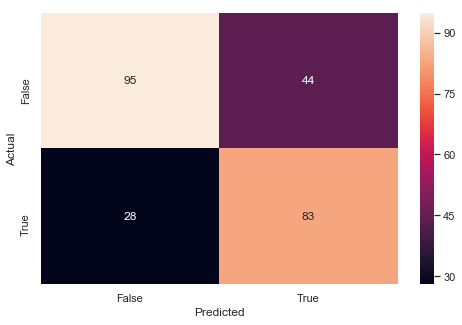

In [292]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_salary_bool = []
for tmp in y_pred_salary:
    if tmp > 0.5:
        y_pred_salary_bool.append(1)
    else :
        y_pred_salary_bool.append(0)

sns.set(rc={'figure.figsize':(8,5)})
g = sns.heatmap(confusion_matrix(y_test_salary,y_pred_salary_bool), annot=True, yticklabels=['False','True'], xticklabels=['False','True'])
g.set_ylabel('Actual')
g.set_xlabel('Predicted');

>False Positive means that when the model predicts salary as more than or equal to median, it is actually less than median. 

>False Negative means that when the modal predicts salary as less than median, it is actually more than or equal to median.

### In the case of our boss, when he saythat he  "would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job", he wants to minimise the false positive rate.

In [316]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_salary, y_pred_salary,pos_label=1)

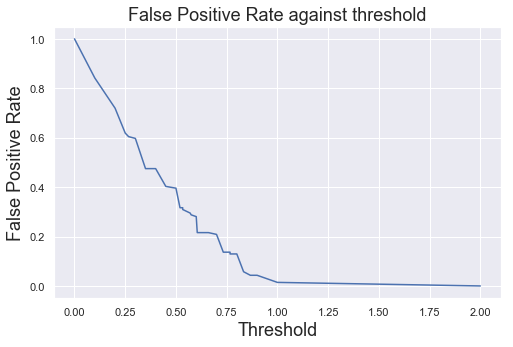

In [331]:
plt.plot(thresholds, fpr)
plt.title('False Positive Rate against threshold', fontsize=18)
plt.xlabel('Threshold', fontsize=18)
plt.ylabel('False Positive Rate', fontsize=18);

In [333]:
### from the graph above, we can see that by increasing the threshold, we reduce the false positive rate.

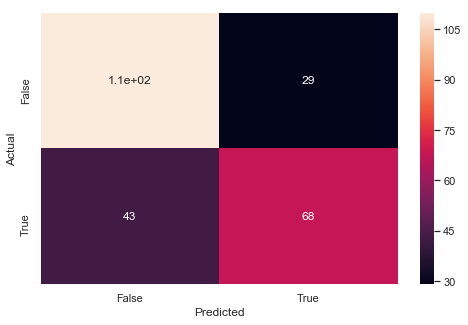

In [335]:
# reduce threshold
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_salary_bool = []
for tmp in y_pred_salary:
    if tmp >= 0.7:
        y_pred_salary_bool.append(1)
    else :
        y_pred_salary_bool.append(0)

sns.set(rc={'figure.figsize':(8,5)})
g = sns.heatmap(confusion_matrix(y_test_salary,y_pred_salary_bool), annot=True, yticklabels=['False','True'], xticklabels=['False','True'])
g.set_ylabel('Actual')
g.set_xlabel('Predicted');
# we can see that false positives has reduced from 44 to 29.

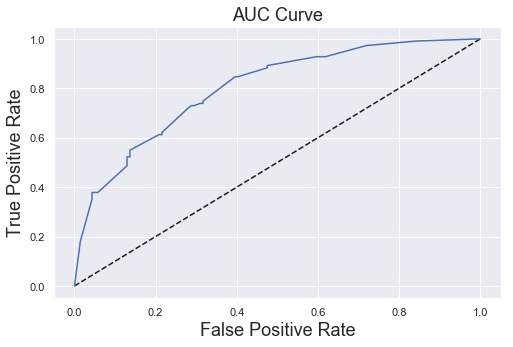

In [326]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.title('AUC Curve', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.show()